### Imports

In [2]:
### Standard imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

###
### SKlearn
###
import sklearn
    ### Metrics
from sklearn.metrics import mean_squared_error, r2_score
    ### Grid Search and time split
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
    ### The four models to be used
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

Import Test-train time series-split data

In [3]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

As well as the shifted data, denoted by 2 after X or y

In [4]:
X2_train = pd.read_csv('data/X2_train.csv')
X2_test = pd.read_csv('data/X2_test.csv')
y2_train = pd.read_csv('data/y2_train.csv')
y2_test = pd.read_csv('data/y2_test.csv')

Make sure the data still looks the same as when it left the pre-processing stage

In [5]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(4105, 18) (4105, 1) (410, 18) (410, 1) (4104, 18) (4104, 1) (410, 18) (410, 1)


Looks Good!

# Modeling

Append all models into a list. 
Useful to run the same fitting, gridsearch, scoring and predict functions in a single loop.
Insert string of acronym of model names for easy referencing during functions

In [6]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))

### Model Cross validation testing

In [7]:
results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    
    if name != 'RFR':
        model.fit(X_train, y_train)
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    else:
        model.fit(X_train, y_train.values.ravel())
        cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names.append(name)
    results.append(cv_results)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -0.797767 (0.628795)
KNN: -1.669319 (1.253311)
XGB: -1.460775 (1.113711)
RFR: -1.215165 (0.929926)


Compare scores of algorithms using boxplots

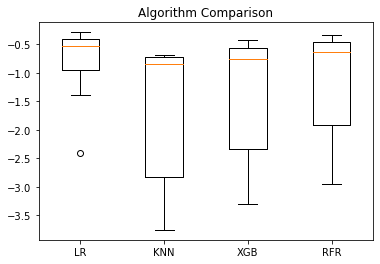

In [8]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Linear Regression seems to be the best performing (closest to zero) while having the least variation as well

Lets plot some scatter plots of the results

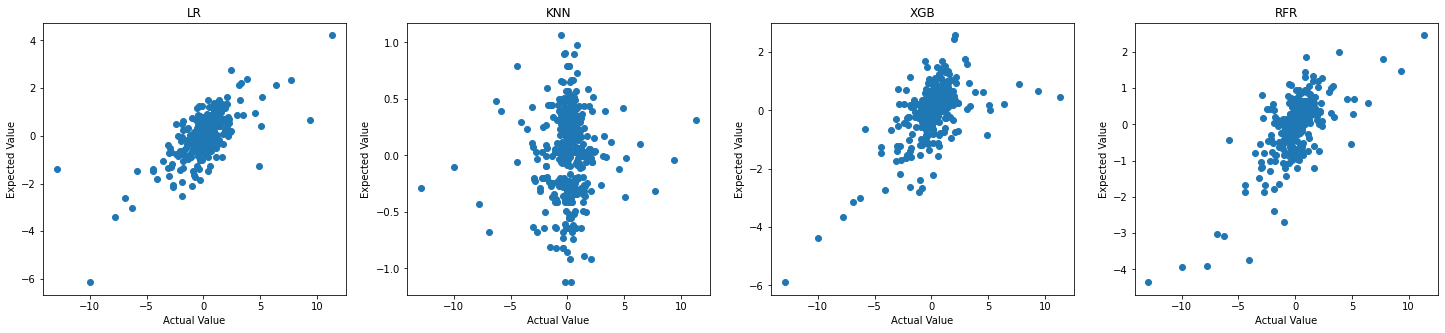

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(25,5))
for i in range(len(models)):
    y_pred_LR = models[i][1].predict(X_test)
    axs[i].scatter(y_test, y_pred_LR)
    axs[i].set(xlabel = 'Actual Value', ylabel ='Expected Value')
    axs[i].set_title(models[i][0])
plt.show()

All models seem to run decently with the exception of KNearestRegressor

Lets try to view the data as a continuous line chart, plotted against the y_test values

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

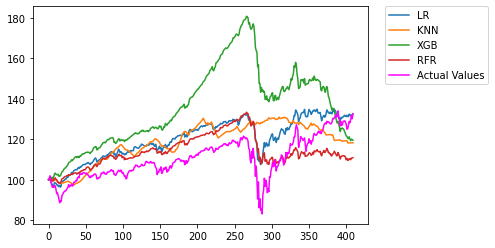

In [10]:
#TWO VARIABLES, ONE MODIFIED BASED ON 100 SCALE, AND THE OTHER THE PREDICT VALUES THEMSELVES
# pct timeline will create an actual percent change based on a 100 factor, and will include the predicted values themselves
pct_timeline = [[100], [100], [100], [100], [100]]
initial_y_pred = []

plt.figure()
for i in range(len(models)):
    y_pred_array = models[i][1].predict(X_test)
    initial_y_pred.append(y_pred_array)
    for x in range(len(y_pred_array)):
        if x != 0:
            pct_timeline[i].append(pct_timeline[i][x -1] + ((y_pred_array[x]/100) * pct_timeline[i][x -1]))
    plt.plot(pct_timeline[i], label=models[i][0])
for val in range(len(y_test)):
    if val != 0:
        pct_timeline[4].append(pct_timeline[4][val -1] + ((y_test.iloc[val]/100) * pct_timeline[4][val -1]))
plt.plot(pct_timeline[4], label= 'Actual Values', color='magenta')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

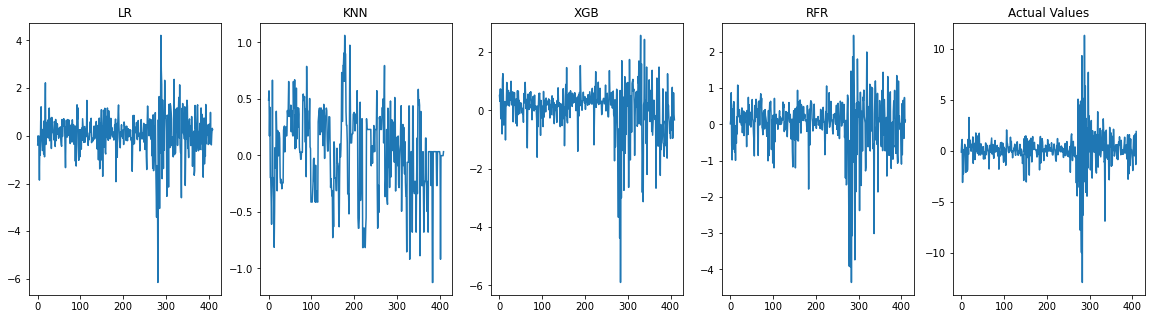

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(20,5))
for pct in range(len(initial_y_pred)):
    axs[pct].plot(initial_y_pred[pct])
    axs[pct].set_title(models[pct][0])
axs[4].plot(y_test)
axs[4].set_title('Actual Values')
plt.show()

Best Base Model so far seems to be close between Linear Regression and Random Forest Regressor
KNN Regressor seems to just get the trend wrong. 
XGBoost gets the trend correct but the scale of the values is less accurate than the main two models

## Initial Model Hyperparameter Tuning

Lets get all available parameters that can be tuned from each model

In [12]:
for name, model in models:
    print(name, model.get_params())

LR {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
KNN {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
XGB {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
RFR {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity

### Grid Search

In [13]:
param_search = {}
param_search['KNN'] = {'n_neighbors' : [1, 5, 10, 20, 50, 100, 200], 'leaf_size' : [5, 10, 20, 30, 50], 'n_jobs' :[-1]}
param_search['XGB'] = {'n_estimators' : [20, 50, 100, 200], 'base_score' : [0.5, 1.0, 2.0], 'learning_rate' : [0.2, 0.3, 0.5, 1.0], 'n_jobs' : [-1]}
param_search['RFR'] = {'n_estimators' : [20, 50, 100, 200], 'n_jobs' : [-1]}
tuned_results = []
tuned_best_score = []
tuned_best_estimator = []
for name, model in models:
    if name != 'LR':
        print(name)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search[name], scoring = 'neg_mean_squared_error')
        if name != 'RFR':
            gsearch.fit(X_train, y_train)
        else :
            gsearch.fit(X_train, y_train.values.ravel())
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        tuned_results.append(gsearch)
        tuned_best_score.append(best_score)
        tuned_best_estimator.append(best_model)
        print(best_score, best_model)

KNN
-1.2367414767293954 KNeighborsRegressor(leaf_size=5, n_jobs=-1, n_neighbors=200)
XGB
-1.1476706434330874 XGBRegressor(base_score=2.0, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
RFR
-1.152169385019526 RandomForestRegressor(n_estimators=200, n_jobs=-1)


### Tuned Model Graphing

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


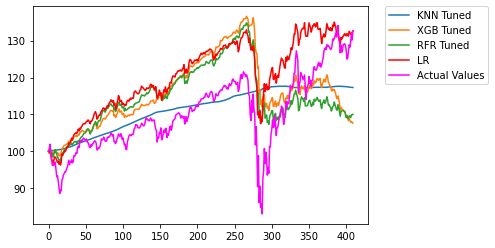

In [14]:
pct_timeline_tuned = [[100], [100], [100], [100], [100]]
tuned_y_pred = []

plt.figure()
for i in range(len(tuned_best_estimator)):
    y_pred_array = tuned_best_estimator[i].predict(X_test)
    tuned_y_pred.append(y_pred_array)
    for x in range(len(y_pred_array)):
        if x != 0:
            pct_timeline_tuned[i].append(pct_timeline_tuned[i][x -1] + ((y_pred_array[x]/100) * pct_timeline_tuned[i][x -1]))
    plt.plot(pct_timeline_tuned[i], label=(list(param_search.keys())[i]) + ' Tuned')
for val in range(len(y_test)):
    if val != 0:
        pct_timeline_tuned[4].append(pct_timeline_tuned[4][val -1] + ((y_test.iloc[val]/100) * pct_timeline_tuned[4][val -1]))
plt.plot(pct_timeline[0], label= 'LR', color='red')
plt.plot(pct_timeline_tuned[4], label= 'Actual Values', color='magenta')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Visually, It seems tuning XGBoost and Random Forest Regressor created closer values, XGBoost especially lost the scaling issue the unrefined model contained. However XGBoost takes up far more computing time than Random Forest Regressor or Linear Regression. And even then its results are comparable to the other two. KNearest Regressor clearly misses the mark, tuned or untuned.

Lets work on the time-shifted models

## Time Shifted Data

First We will get rid of XGBoost and KNearest Regressor

In [15]:
model_list = []
model_list.append(('LR', LinearRegression()))
model_list.append(('RFR', RandomForestRegressor()))

### Initial Models Cross Validation

In [16]:
results2 = []
names2 = []

for name, model in model_list:
    tscv = TimeSeriesSplit(n_splits=10)
    
    if name != 'RFR':
        model.fit(X2_train, y2_train)
        cv_results2 = cross_val_score(model, X2_train, y2_train, cv=tscv, scoring='neg_mean_squared_error')
    else:
        model.fit(X2_train, y2_train.values.ravel())
        cv_results2 = cross_val_score(model, X2_train, y2_train.values.ravel(), cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names2.append(name)
    results2.append(cv_results2)
    
    print('%s: %f (%f)' % (name, cv_results2.mean(), cv_results2.std()))

LR: -1.212995 (0.958964)
RFR: -1.707639 (1.200057)


Compare Algorithms

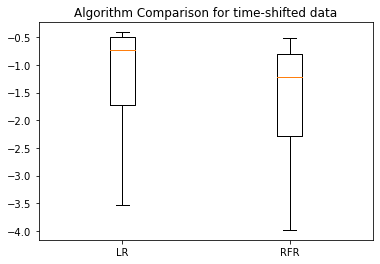

In [17]:
plt.boxplot(results2, labels=names2)
plt.title('Algorithm Comparison for time-shifted data')
plt.show()

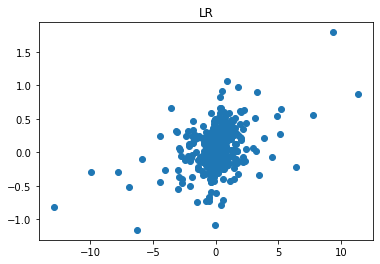

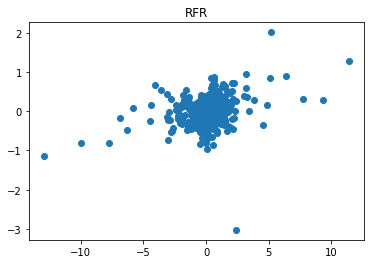

In [18]:
for i in range(len(model_list)):
    plt.figure()
    y_pred_LR2 = model_list[i][1].predict(X2_test)
    plt.scatter(y2_test, y_pred_LR2)
    plt.title(model_list[i][0])
    plt.show()

Both models seem promising

### Hyperparameter Tuning

This time, only Random Forest Regressor needs to be Tuned

In [19]:
param_search_RFR = {'n_estimators' : [20, 50, 100, 200], 'n_jobs' : [-1]}
tuned_shift_RFR = []
tuned_best_score_RFR = []
tuned_best_estimator_RFR = []
gsearch_RFR = GridSearchCV(estimator=model_list[1][1], cv=tscv, param_grid=param_search_RFR, scoring = 'neg_mean_squared_error')
gsearch_RFR.fit(X2_train, y2_train.values.ravel())
tuned_shift_RFR.append(gsearch_RFR)
tuned_best_score_RFR.append(gsearch_RFR.best_score_)
tuned_best_estimator_RFR.append(gsearch_RFR.best_estimator_)
print(tuned_best_score_RFR, tuned_best_estimator_RFR)

[-1.7326978958530446] [RandomForestRegressor(n_estimators=200, n_jobs=-1)]


Now we plot the predictor models and see how they match up against the actual y test values

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


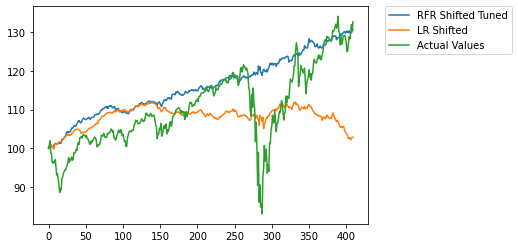

In [20]:
pct_new = [[100], [100], [100]]
tuned_y_pred_sft = tuned_best_estimator_RFR[0].predict(X2_test)
LR_shifted_ypred = model_list[0][1].predict(X2_test)
#plt.figure()
for h in range(len(LR_shifted_ypred)):
    if h != 0:
        pct_new[0].append(pct_new[0][h -1] + ((LR_shifted_ypred[h]/100) * pct_new[0][h -1]))
for w in range(len(tuned_y_pred_sft)):
    if w != 0:
        pct_new[1].append(pct_new[1][w -1] + ((tuned_y_pred_sft[w]/100) * pct_new[1][w -1]))
for b in range(len(y2_test)):
    if b != 0:
        pct_new[2].append(pct_new[2][b -1] + ((y2_test.iloc[b]/100) * pct_new[2][b -1]))
plt.plot(pct_new[0], label=('RFR Shifted Tuned'))
plt.plot(pct_new[1], label=('LR Shifted'))
plt.plot(pct_new[2], label=('Actual Values'))
#plt.plot(pct_timeline[0], label= 'LR', color='red')
#plt.plot(pct_timeline_tuned[4], label= 'Actual Values', color='magenta')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

It seems shifting the datasets one day back based on GMT time makes for less accurate modeling predictions. 

## Conclusion

In short, there seems to be a decent correlation in using a single index to predict the values of other indeces in different timezones and exchanges in terms of percent change. The best model to use would be Linear Regression on data from the same day. It takes less computing time than Ranfom Forest Regressor and significantly less than XGBoost for similar results.